## Project 1 – Parts g & h: Bias–Variance with Bootstrap and Cross‑Validation

# Imports and seed

In [1]:
from functions import *

from pathlib import Path
import matplotlib.pyplot as plt

out_dir = Path("../Figures")      # fra Code/ til Figures/
out_dir.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12,
})

seed = 2018

# Del g: Bootstrap-estimate av Bias, Varians og MSE (OLS)

In [2]:
#Define n
n_points_list = [100, 500, 1000, 2000, 5000, 7000, 10000]
#Define degrees
degrees = list(range(1, 15)) #polynomial degrees

B = 200 #number of bootstrap replicates

# Make dataset for bootstrap

In [3]:
results_by_n = {}

for n_points in n_points_list:

    (train, test, full) = make_data(n=n_points)

    x_train, y_train = train
    x_test, y_test = test
    x_all, y_all, y_all_clean = full 

    boot = bootstrap(degrees, x_train, x_test, y_train, y_test, B, seed=seed)
    
    #Unpack
    deg = boot["degree"]

    train_mse = boot["train_mse"]
    test_mse  = boot["test_mse"]

    mse_boots = boot["mse_boots"]
    bias_boots = boot["bias2_boots"]
    var_boots = boot["var_boots"]

    results_by_n[n_points] = {
        "degree": np.asarray(deg),
        "train_mse": np.asarray(train_mse),
        "test_mse": np.asarray(test_mse),
        "mse_boots": np.asarray(mse_boots),
        "bias_boots": np.asarray(bias_boots),
        "var_boots": np.asarray(var_boots),
    }

# Plot: Train/Test-MSE vs degree (OLS without bootstrap)

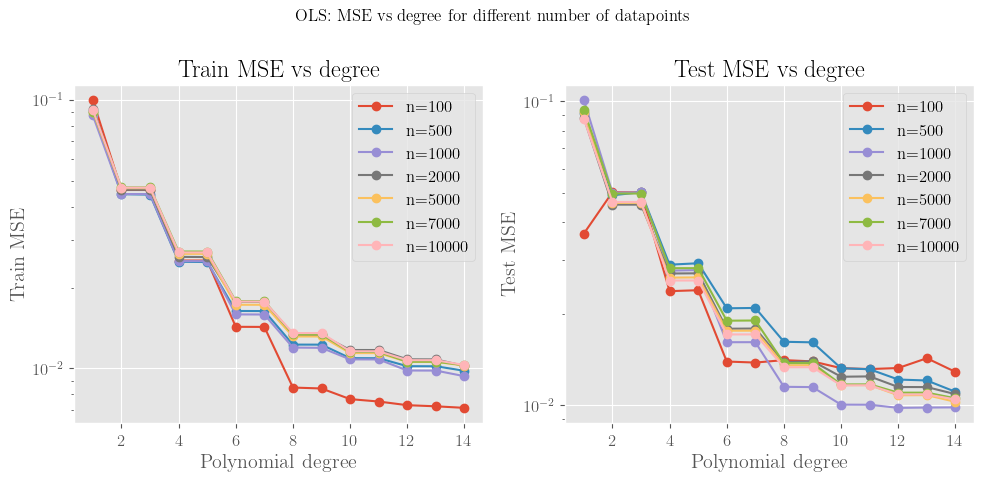

In [4]:
# --- plotting ---
plt.figure(figsize=(10, 4.8))

#Left: Train MSE
plt.subplot(1, 2, 1)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    tr = results_by_n[n_points]["train_mse"]
    plt.semilogy(d, tr, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Train MSE')
plt.title('Train MSE vs degree')
plt.legend()
plt.tight_layout()

#Right: Test MSE
plt.subplot(1, 2, 2)
for n_points in n_points_list:
    d = results_by_n[n_points]["degree"]
    te = results_by_n[n_points]["test_mse"]
    plt.semilogy(d, te, marker='o', linewidth=1.5, label=f'n={n_points}')
plt.xlabel('Polynomial degree')
plt.ylabel('Test MSE')
plt.title('Test MSE vs degree')
plt.legend()
plt.tight_layout()

plt.suptitle('OLS: MSE vs degree for different number of datapoints', y=1.0, fontsize=12)
plt.tight_layout()

plt.savefig(out_dir / "G_OLS_train_test_MSE.pdf" , dpi=200, bbox_inches="tight")

plt.show()

# Plot: Bias², Varians, MSE (bootstrap) vs degree

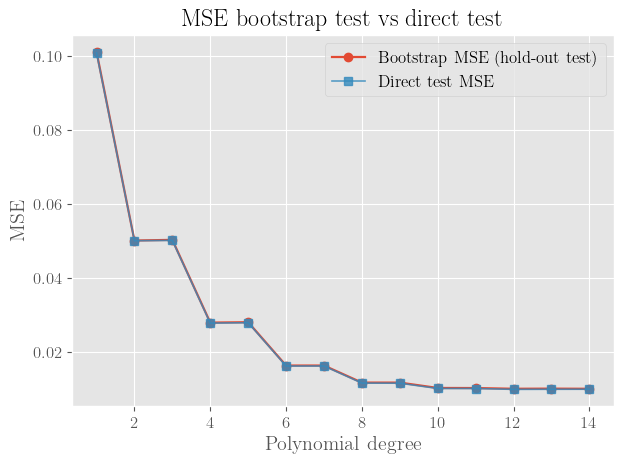

In [5]:
plt.figure()
plt.plot(deg, results_by_n[1000]["mse_boots"], marker='o', linewidth=1.6,
         label='Bootstrap MSE (hold-out test)')
# valgfritt: legg på direkte test-MSE fra én fit per grad (referanse)
plt.plot(deg, results_by_n[1000]["test_mse"], marker='s', linewidth=1.2, alpha=0.8,
         label='Direct test MSE')

plt.xlabel('Polynomial degree')
plt.ylabel('MSE')
plt.title('MSE bootstrap test vs direct test')
plt.legend()
plt.tight_layout()

plt.savefig(out_dir / "G_OLS_boot_vs_direct_MSE.pdf" , dpi=200, bbox_inches="tight")

plt.show()

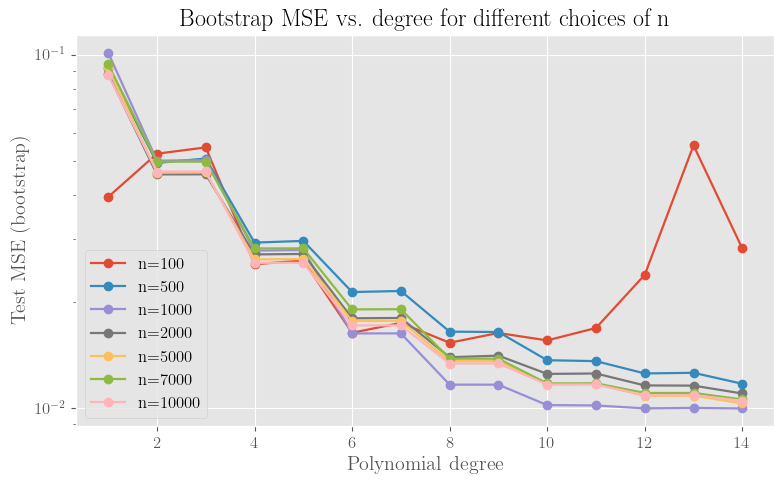

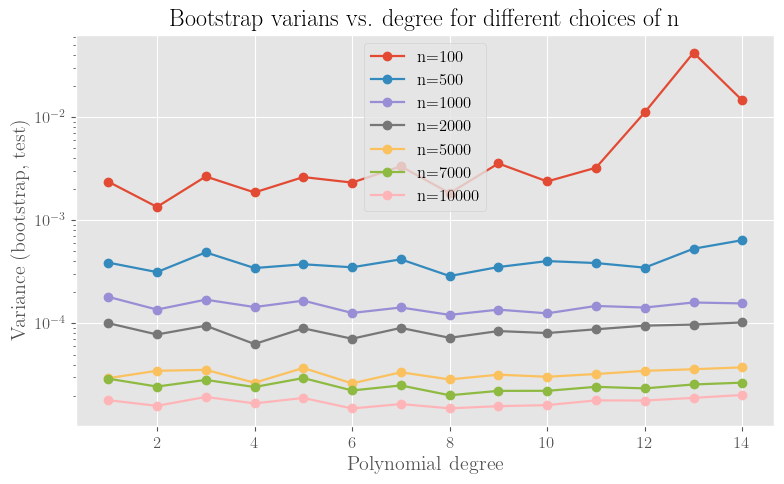

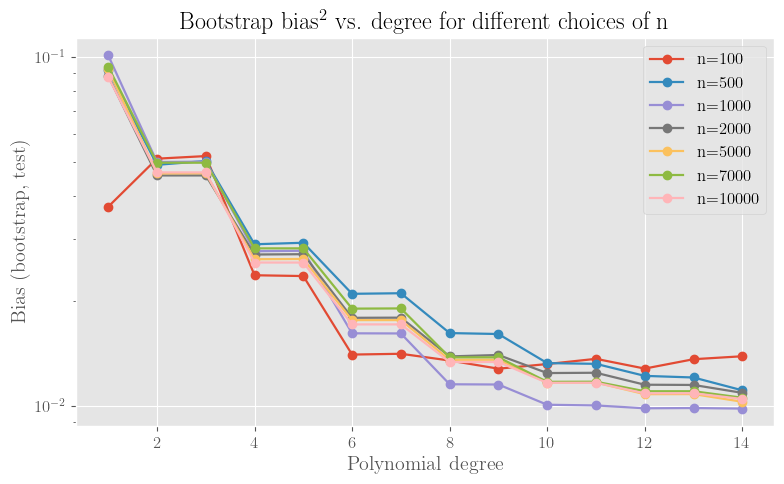

In [6]:
# --- 1) MSE (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["mse_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel("Test MSE (bootstrap)")
plt.title("Bootstrap MSE vs. degree for different choices of n")
plt.legend()
plt.tight_layout()

plt.savefig(out_dir / "G_boots_mse.pdf" , dpi=200, bbox_inches="tight")

plt.show()

# --- 2) Varians (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["var_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel("Variance (bootstrap, test)")
plt.title("Bootstrap varians vs. degree for different choices of n")
plt.legend()
plt.tight_layout()

plt.savefig(out_dir / "G_boots_var.pdf" , dpi=200, bbox_inches="tight")

plt.show()

# --- 3) Bias^2 (bootstrap) vs degree ---
plt.figure(figsize=(8,5))
for n in n_points_list:
    plt.semilogy(degrees, results_by_n[n]["bias_boots"], marker='o', linewidth=1.6, label=f"n={n}")
plt.xlabel("Polynomial degree")
plt.ylabel(r"Bias (bootstrap, test)")
plt.title(r"Bootstrap bias$^2$ vs. degree for different choices of n")
plt.legend()
plt.tight_layout()

plt.savefig(out_dir / "G_boots_bias.pdf" , dpi=200, bbox_inches="tight")

plt.show()


# Part h: k-fold CV for OLS – MSE vs degree

In [7]:
#Generate a new dataset for part h) k-fold 
n_k_fold = 10000 

(train, test, full) = make_data(n=n_k_fold)

x_train, y_train = train
x_test, y_test = test
x_all, y_all, y_all_clean = full 

K = 10 #number of k-folds

lambdas = np.logspace(-4, -1, 15) #feilen "straffen" i ridge og lasso

In [8]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, K, x_train, y_train) for d in degrees])

# Plot

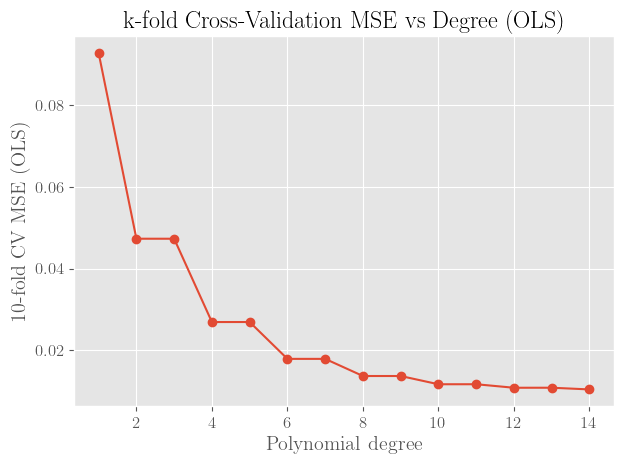

The best polynomial degree for ols is: 14


In [9]:
plt.figure()
plt.plot(degrees, cv_mse_ols, marker='o')
plt.xlabel('Polynomial degree')
plt.ylabel(f'{K}-fold CV MSE (OLS)')
plt.title('k-fold Cross-Validation MSE vs Degree (OLS)')
plt.tight_layout()

plt.savefig(out_dir / "H_mse_vs_degree.pdf" , dpi=200, bbox_inches="tight")

plt.show()

best_deg_ols = int(degrees[np.argmin(cv_mse_ols)])

print(f"The best polynomial degree for ols is: {best_deg_ols}")

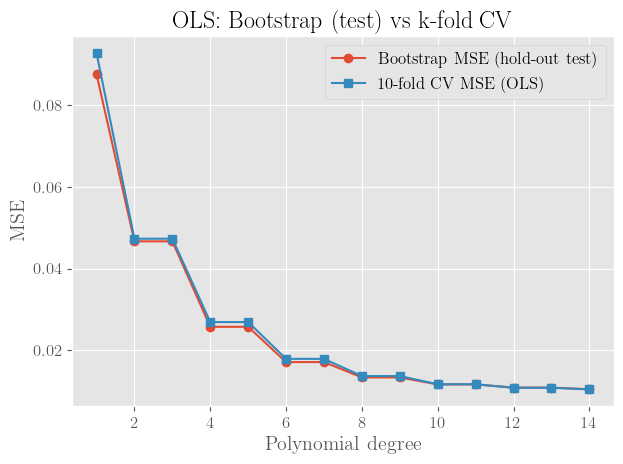

In [10]:
cv_mse_ols = np.array([kfold_cv_mse_ols(d, K, x_train, y_train) for d in degrees])

plt.figure()
plt.plot(deg, boot["mse_boots"], marker='o', label='Bootstrap MSE (hold-out test)')
plt.plot(deg, cv_mse_ols,            marker='s', label=f'{K}-fold CV MSE (OLS)')
plt.xlabel('Polynomial degree') 
plt.ylabel('MSE')
plt.title('OLS: Bootstrap (test) vs k-fold CV')
plt.legend()
plt.tight_layout()

plt.savefig(out_dir / "H_boot_mse_vs_kfold_mse.pdf" , dpi=200, bbox_inches="tight")

plt.show()

# CV-kurver for Ridge og Lasso (utvalgte grader)

In [11]:
best_ridge, best_lasso = {}, {}

cv_mse_ridge = {d: cv_for_methods('ridge', d, lambdas, K, x_train, y_train)
for d in degrees}
cv_mse_lasso = {d: cv_for_methods('lasso', d, lambdas, K, x_train, y_train) 
for d in degrees}

# Plot

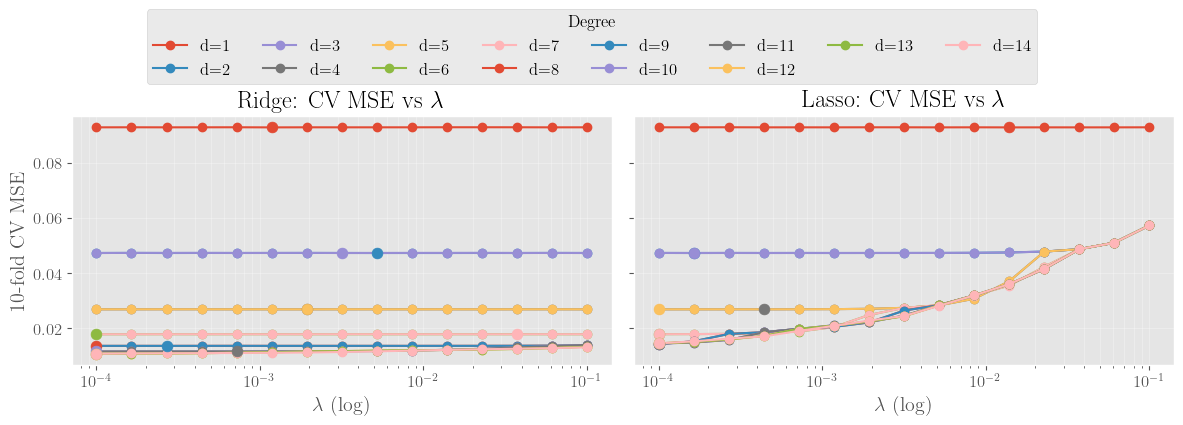

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
ax_ridge, ax_lasso = axes

# --- Ridge ---
for d in degrees:
    res = cv_mse_ridge[d]
    order = np.argsort(res["lambdas"])
    ax_ridge.semilogx(res["lambdas"][order], res["cv_mse"][order],
                      marker='o', linewidth=1.5, label=f'd={d}')
    ax_ridge.scatter(res["best_lambda"], res["best_mse"], s=60, zorder=3)

ax_ridge.set_title(r'Ridge: CV MSE vs $\lambda$')
ax_ridge.set_xlabel(r'$\lambda$ (log)')
ax_ridge.set_ylabel(f'{K}-fold CV MSE')
ax_ridge.grid(True, which='both', alpha=0.3)

# --- Lasso ---
for d in degrees:
    res = cv_mse_lasso[d]
    order = np.argsort(res["lambdas"])
    ax_lasso.semilogx(res["lambdas"][order], res["cv_mse"][order],
                      marker='o', linewidth=1.5, label=f'd={d}')
    ax_lasso.scatter(res["best_lambda"], res["best_mse"], s=60, zorder=3)

ax_lasso.set_title(r'Lasso: CV MSE vs $\lambda$')
ax_lasso.set_xlabel(r'$\lambda$ (log)')
ax_lasso.grid(True, which='both', alpha=0.3)

# --- felles legend (hent handles/labels fra én akse) ---
handles, labels = ax_ridge.get_legend_handles_labels()
fig.legend(handles, labels, title='Degree', ncol=8, loc='upper center',
           bbox_to_anchor=(0.5, 1.08))

plt.tight_layout(rect=[0, 0, 1, 0.90])  # gi plass til legend på toppen

plt.savefig(out_dir / "H_mse_vs_lambda.pdf" , dpi=200, bbox_inches="tight")

plt.show()


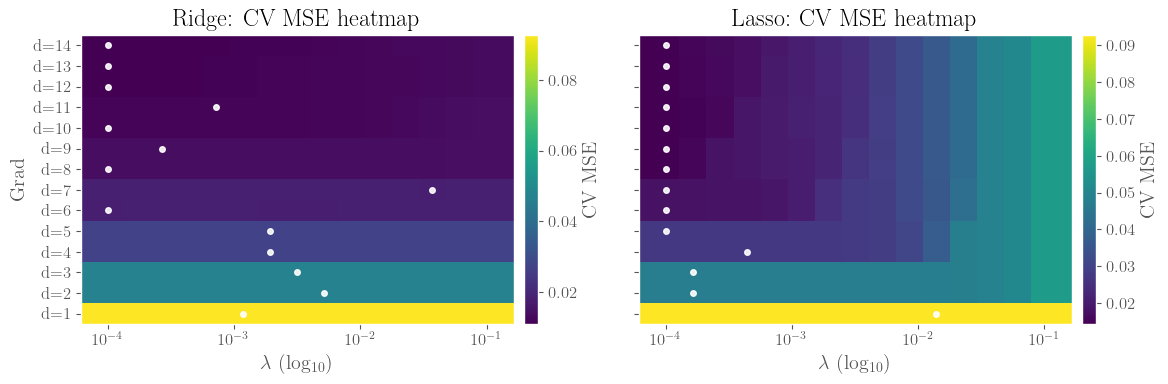

In [13]:
def _build_heatmap_matrix(results_by_deg):
    """
    results_by_deg: dict[d] -> {"lambdas": array, "cv_mse": array, "best_lambda": float, "best_mse": float}
    Returnerer:
        degrees_sorted (list),
        lambdas_common (array),
        H (2D array shape [n_deg, n_lam]) med CV-MSE,
        best_points (list of tuples (row_i, best_lambda, best_mse))
    """
    degrees_sorted = sorted(results_by_deg.keys())
    # Samle ALLE lambdaer (kan være identiske for alle d; hvis ikke, lager vi felles grid)
    all_lams = np.unique(np.concatenate([np.asarray(results_by_deg[d]["lambdas"]) for d in degrees_sorted]))
    # Vi jobber i log10-rom for jevnere interpolasjon og akse
    lam_log = np.log10(all_lams)
    lam_log.sort()
    lambdas_common = 10**lam_log

    H = np.zeros((len(degrees_sorted), len(lambdas_common)))
    best_points = []

    for i, d in enumerate(degrees_sorted):
        lam_d = np.asarray(results_by_deg[d]["lambdas"])
        mse_d = np.asarray(results_by_deg[d]["cv_mse"])
        order = np.argsort(lam_d)
        lam_d = lam_d[order]
        mse_d = mse_d[order]
        # Interpoler i log-lambda
        H[i, :] = np.interp(lam_log, np.log10(lam_d), mse_d)
        best_points.append((i, results_by_deg[d]["best_lambda"], results_by_deg[d]["best_mse"]))
    return degrees_sorted, lambdas_common, H, best_points

# Bygg matriser
deg_r, lam_r, H_r, best_r = _build_heatmap_matrix(cv_mse_ridge)
deg_l, lam_l, H_l, best_l = _build_heatmap_matrix(cv_mse_lasso)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axR, axL = axes

def _plot_heat(ax, lambdas, degrees, H, title, best_points):
    # x-akse i log10(lambda) men viser ticklabels som lambda
    x = np.log10(lambdas)
    # pcolormesh trenger kant-gitter; lag fra sentre
    x_edges = np.concatenate(([x[0] - (x[1]-x[0])], (x[:-1]+x[1:])/2, [x[-1] + (x[-1]-x[-2])]))
    y = np.arange(len(degrees), dtype=float)
    y_edges = np.concatenate(([y[0]-0.5], y[1:]-0.5, [y[-1]+0.5]))

    mesh = ax.pcolormesh(x_edges, y_edges, H, shading='auto')
    cbar = plt.colorbar(mesh, ax=ax, pad=0.02)
    cbar.set_label('CV MSE')

    # Marker beste punkt per grad
    for row_i, blam, bmse in best_points:
        ax.plot(np.log10(blam), row_i, marker='o', markersize=4, mec='white', mfc='white', alpha=0.9)

    ax.set_title(title)
    ax.set_xlabel(r'$\lambda$ (log$_{10}$)')
    ax.set_yticks(np.arange(len(degrees)))
    ax.set_yticklabels([f'd={d}' for d in degrees])
    ax.grid(False)

    # Penere x-ticks: velg noen få lambda-verdier
    xticks_log = np.log10(np.array([1e-4, 1e-3, 1e-2, 1e-1]))
    ax.set_xticks(xticks_log)
    ax.set_xticklabels([r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$'])

_plot_heat(axR, lam_r, deg_r, H_r, 'Ridge: CV MSE heatmap', best_r)
axR.set_ylabel('Grad')

_plot_heat(axL, lam_l, deg_l, H_l, 'Lasso: CV MSE heatmap', best_l)

plt.tight_layout()

plt.savefig(out_dir / "H_mse_vs_lambda_heatmap.pdf" , dpi=200, bbox_inches="tight")

plt.show()


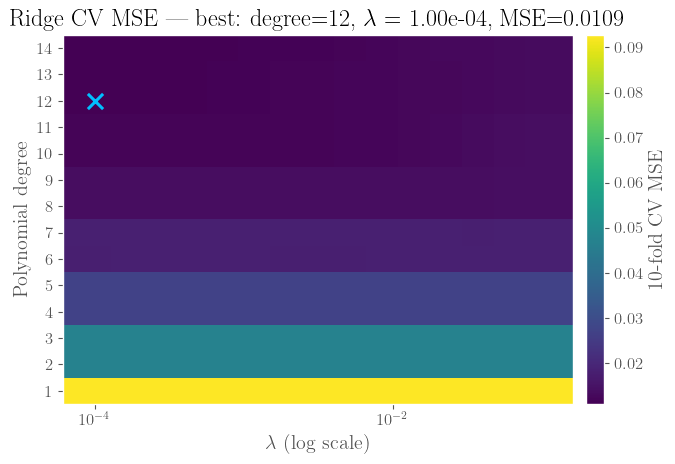

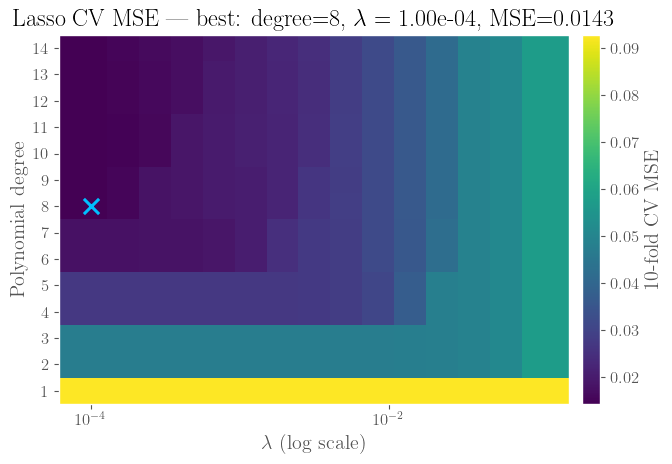

In [14]:
fig, ax, best_ridge = plot_cv_heatmap_with_best(cv_mse_ridge, "Ridge CV MSE", n_k_folds=K)

fig.savefig(out_dir / "H_Ridge_CV_heatmap.pdf", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)

fig, ax, best_lasso = plot_cv_heatmap_with_best(cv_mse_lasso, "Lasso CV MSE", n_k_folds=K)
fig.savefig(out_dir / "H_Lasso_CV_heatmap.pdf", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)


# Sammenlign OLS/Ridge/Lasso og vis beste modeller

In [15]:
best_ridge = cv_mse_ridge
best_lasso = cv_mse_lasso

rows = []
for d in degrees:
    ols_cv_mse = kfold_cv_mse_ols(d, K, x_train, y_train)

    rr = best_ridge[d]; ll = best_lasso[d]
    rows.append({
        "degree": d,
        "ols_cv_mse": ols_cv_mse,
        "ridge_best_lambda": rr["best_lambda"],
        "ridge_best_mse": rr["best_mse"],
        "lasso_best_lambda": ll["best_lambda"],
        "lasso_best_mse": ll["best_mse"],
    })
summary_df = pd.DataFrame(rows).sort_values("degree").reset_index(drop=True)

summary_df

,degree,ols_cv_mse,ridge_best_lambda,ridge_best_mse,lasso_best_lambda,lasso_best_mse
0,1,0.092760,0.001179,0.092740,0.013895,0.092738
1,2,0.047320,0.005179,0.047294,0.000164,0.047298
2,3,0.047299,0.003162,0.047300,0.000164,0.047304
3,4,0.026934,0.001931,0.026918,0.000439,0.026917
4,5,0.026935,0.001931,0.026918,0.000100,0.026919
5,6,0.017911,0.000100,0.017906,0.000100,0.017935
6,7,0.017905,0.037276,0.017904,0.000100,0.017929
7,8,0.013710,0.000100,0.013705,0.000100,0.014347
8,9,0.013710,0.000268,0.013707,0.000100,0.014348
9,10,0.011699,0.000100,0.011696,0.000100,0.014562


# Plott: Metodesammenligning (CV-MSE)

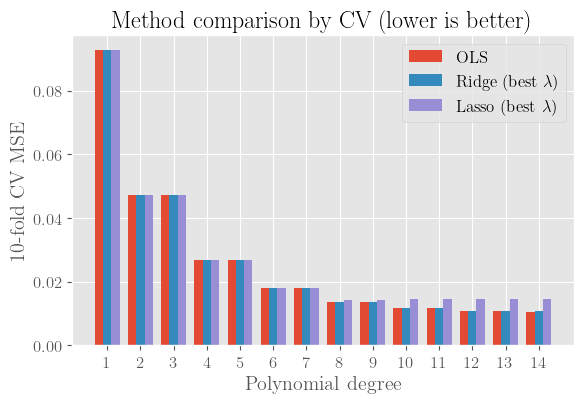

In [16]:
idx = np.arange(len(summary_df))
width = 0.25 

fig = plt.figure(figsize=(6, 4.2))
plt.bar(idx - width, summary_df["ols_cv_mse"], width=width, label='OLS')
plt.bar(idx,         summary_df["ridge_best_mse"], width=width, label=r'Ridge (best $\lambda$)')
plt.bar(idx + width, summary_df["lasso_best_mse"], width=width, label=r'Lasso (best $\lambda$)')
plt.xticks(idx, [str(d) for d in summary_df["degree"]])
plt.xlabel('Polynomial degree')
plt.ylabel(f'{K}-fold CV MSE')
plt.title('Method comparison by CV (lower is better)')
plt.legend()
plt.tight_layout()

fig.savefig(out_dir / "H_method_comparison.pdf", dpi=200, bbox_inches="tight")

plt.show()

# Tren beste modeller og rapporter hold-out Test-MSE

OLS   (deg=14)                  Test MSE: 0.010154
Ridge (deg=12, alpha=1.000e-04) Test MSE: 0.011365
Lasso (deg=8, alpha=1.000e-04) Test MSE: 0.017533


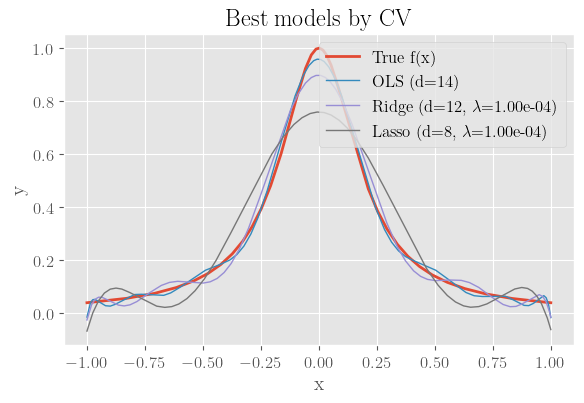

In [17]:
best_deg_ols  = int(degrees[np.argmin(cv_mse_ols)])

# Finn globalt beste for Ridge/Lasso fra dine resultatsamlinger:
best_deg_ridge = int(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["degree"])
best_lambda_ridge = float(summary_df.iloc[summary_df["ridge_best_mse"].idxmin()]["ridge_best_lambda"])
best_deg_lasso = int(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["degree"])
best_lambda_lasso = float(summary_df.iloc[summary_df["lasso_best_mse"].idxmin()]["lasso_best_lambda"])

x_dense = np.linspace(-1, 1, 400)

ols_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ols, include_bias=True),
    LinearRegression(fit_intercept=False)
)
ols_model.fit(x_train.reshape(-1,1), y_train)

ridge_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_ridge, include_bias=True),
    Ridge(alpha=best_lambda_ridge, fit_intercept=False, random_state=seed)
)
ridge_model.fit(x_train.reshape(-1,1), y_train)

lasso_model = make_pipeline(
    PolynomialFeatures(degree=best_deg_lasso, include_bias=True),
    Lasso(alpha=best_lambda_lasso, fit_intercept=False,
          max_iter=300_000, tol=1e-3, selection="cyclic", random_state=seed)
)
lasso_model.fit(x_train.reshape(-1,1), y_train)

ols_test_mse   = mse(y_test,  ols_model.predict(x_test.reshape(-1,1)).ravel())
ridge_test_mse = mse(y_test, ridge_model.predict(x_test.reshape(-1,1)).ravel())
lasso_test_mse = mse(y_test, lasso_model.predict(x_test.reshape(-1,1)).ravel())

print(f"OLS   (deg={best_deg_ols})                  Test MSE: {ols_test_mse:.6f}")
print(f"Ridge (deg={best_deg_ridge}, alpha={best_lambda_ridge:.3e}) Test MSE: {ridge_test_mse:.6f}")
print(f"Lasso (deg={best_deg_lasso}, alpha={best_lambda_lasso:.3e}) Test MSE: {lasso_test_mse:.6f}")

fig = plt.figure(figsize=(6, 4.2))

#plt.scatter(x_train, y_train, s=20, alpha=0.2, label='Train (noisy)')
#plt.scatter(x_test,  y_test,  s=20, alpha=0.2, label='Test (noisy)')
plt.plot(x_dense, f_true(x_dense), linewidth=2, label='True f(x)')
plt.plot(x_dense, ols_model.predict(x_dense.reshape(-1,1)).ravel(),   linewidth=1, label=f'OLS (d={best_deg_ols})')
plt.plot(x_dense, ridge_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Ridge (d={best_deg_ridge}, $\\lambda$={best_lambda_ridge:.2e})')
plt.plot(x_dense, lasso_model.predict(x_dense.reshape(-1,1)).ravel(), linewidth=1, label=f'Lasso (d={best_deg_lasso}, $\\lambda$={best_lambda_lasso:.2e})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best models by CV')
plt.legend()
plt.tight_layout()

fig.savefig(out_dir / "H_best_models_by_CV.pdf", dpi=200, bbox_inches="tight")

plt.show()
